[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/planetlabs/notebooks/blob/master/jupyter-notebooks/use_cases/calculate_water_extent_analysis_ready_planetscope/calculate_water_extent_analysis_ready_planetscope.ipynb)
# Intro to ARPS data in Planet Insights Platform

Welcome to an intro to using Analysis-Ready PlanetScope (ARPS) within the Planet Insights Platform. ARPS is a new offering from Planet that accelerates your analytical workflows with pre-processed, harmonized satellite imagery. In this demo we are going to be using the ARPS tile near Perth, Australia that is available within [Planet Sandbox Data](https://docs.planet.com/data/imagery/arps/sandbox/). We will be observing the changing water level of a reservoir throughout the year. 

* Step 1: Visualize imagery using the Processing API

* Step 2: Create a time series using the Statistical API

* Step 3: Water classifiaction using thresholds

This notebook makes use of [Planet Sandbox Data](https://docs.planet.com/data/planet-sandbox-data/). You need a Planet account in order to access this data. If you don't already have an account, you can [sign up for a 30-day trial](https://insights.planet.com/sign-up/).

In [ ]:
# If necessary, uncomment the following line and run this cell to install required packages (for example, if you are using Colab).
#%pip install -q sentinelhub --quiet

In [2]:
%matplotlib inline

import calendar
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import getpass 

from sentinelhub import (
    CRS,
    DataCollection,
    MimeType,
    SentinelHubRequest,
    SentinelHubStatistical,
    SHConfig,
    parse_time,
    BBox,
    bbox_to_dimensions,
)

## Credentials

The Sentinel Hub Python SDK requires a `client_id` and a `client_secret`. To obtain your `client_id` & `client_secret`, you need to navigate to your [account manager](insights.planet.com/account/), and in the **User Settings**, create a new OAuth client. More detailed instructions can be found in our [authentication documentation](https://docs.planet.com/develop/authentication/).

Once you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [in the documentation](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). This is useful as changes to the config class in your notebook are usually only temporary and by saving the configuration to your profile, you don't have to generate new credentials or overwrite the default profile every time you run a new Jupyter Notebook.

The following cell checks for an existing default configuration. If none is found, you will be prompted for your credentials, which you can then optionally save.

In [ ]:
from sentinelhub import SHConfig

# Authenticate with the Sentinel Hub Python SDK; See docs: https://sentinelhub-py.readthedocs.io/en/latest/configure.html and https://docs.planet.com/develop/authentication
# If no default configuration detected, enter a client ID and secret to authenticate. These can be obtained by creating an OAuth client here: https://insights.planet.com/account
config = SHConfig()
if not config.sh_client_id or not config.sh_client_secret:
    from getpass import getpass
    print('No credentials found, please provide the OAuth client ID and secret.')
    config.sh_client_id = getpass('Client ID: ')
    config.sh_client_secret = getpass('Client Secret: ')
    ## Uncomment the following lines to save your credentials to a configuration
    # config.save() 
    # print(f'Credentials saved to {SHConfig.get_config_location()}')
else:
    print(f'Using credentials stored here: {SHConfig.get_config_location()}')

In [4]:
#This is the collection ID for the sandbox collection 
collection_id = "3f605f75-86c4-411a-b4ae-01c896f0e54e"

#Coordinates for Lake C.Y. O'Connor outside of Perth, Western Australia
lake_aoi = (116.16437,-31.970731, 116.182909,-31.955166)


In [5]:
#Resolution of the ARPS
resolution = 3

#Create a bounding box for the lake
lake_bbox = BBox(bbox=lake_aoi, crs=CRS.WGS84)
lake_size = bbox_to_dimensions(lake_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {lake_size} pixels")

Image shape at 3 m resolution: (580, 580) pixels


## Step 1: Visualize imagery using the Processing API
### Visualize RGB

In order to visualize imagery from Sentinel Hub we need to use evalscripts, the JavaScript instructions for the Processing API, [described in more details here](https://docs.sentinel-hub.com/api/latest/evalscript/). This script takes the Red, Green, Blue band of APRS data and divides the values by 1000 as the API will return values between 0-255 and the ARPS data is a SR reflectance product that spans approximately 0-10,000.

In [6]:
vis_eval = """
//VERSION=3
//True Color

function setup() {
  return {
    input: ["blue", "green", "red", "dataMask"],
    output: { bands: 4 }
  };
}

function evaluatePixel(sample) {
  return [sample.red/1000, sample.green/1000, sample.blue/1000, sample.dataMask];
}
"""

### ATTENTION! 
ARPS data is a composite of multiple images on the same day, meaning it has no time attribute, just a date. The imagery is tagged at `00:00:00`, to avoid unwanted outputs specify the aquisition time as midday, straddling the midnight timeslot that ARPS is set to. 

The ARPS metadata does include the scene IDs, which are timestamps, however SH does not allow you to access the metadata as of now. If you are hosting your own ARPS data however that information is available.

In [7]:
# Now we make a processing api call to the get the mean value of each pixel for the AOI and the date range.
def request_data(eval, start, end):
    data_collection = DataCollection.define_byoc(collection_id)

    return SentinelHubRequest(  # Create a request for the mean value
        evalscript=eval,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(start, end)
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=lake_bbox,
        size=lake_size,
        config=config,

        data_folder="../data",
    )

vis =  request_data(vis_eval,"2023-03-02T12:00:00Z", "2023-03-03T12:00:00Z") 


In [8]:
visual = vis.get_data()[0]

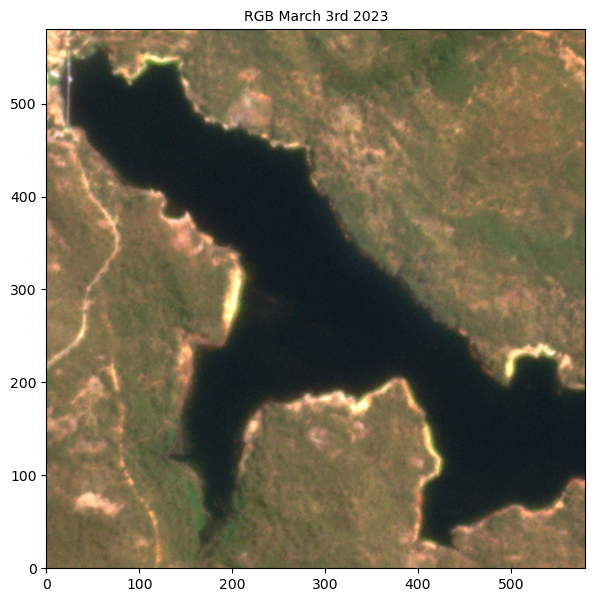

In [9]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(7, 7))

ax = axs
aspect_ratio = lake_size[1] / lake_size[0]  # Calculate the aspect ratio
ax.imshow(visual, aspect=aspect_ratio, extent=[0, lake_size[0], 0, lake_size[1]])
ax.set_title(f"RGB March 3rd 2023", fontsize=10)

plt.show()

### Visualize NDWI

Using the Processing API we are not just bound to RGB images, evalscripts can return any multi-band imagery that has the same data type. In this case we are going to calculate the Normalized Difference Water Index and return a 32 bit floating point band. 

In [10]:
ndwi_eval = """
//VERSION=3
//NDWI

function setup() {
  return {
    input: ["green", "nir", "dataMask"],
    output: { bands: 1, sampleType: "FLOAT32" }
  };
}

function evaluatePixel(sample) {
  var ndwi = (sample.green - sample.nir ) / (sample.green  + sample.nir );
  return [ndwi];
}
"""

In [11]:
ndwi = request_data(ndwi_eval,"2023-03-02T12:00:00Z", "2023-03-03T12:00:00Z").get_data()[0]

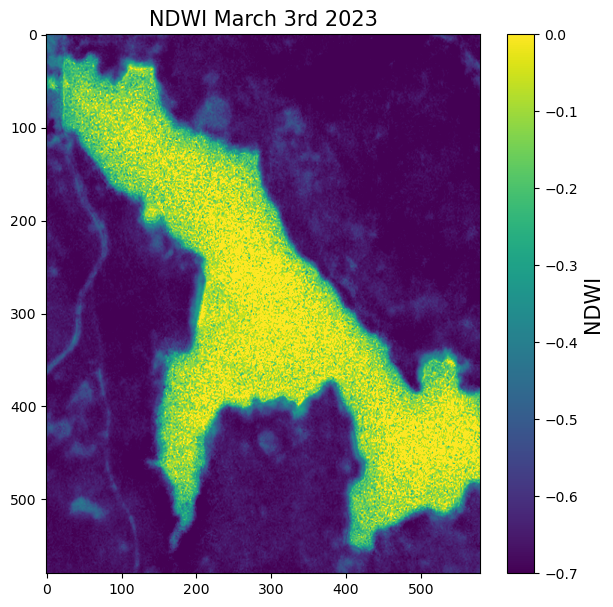

In [12]:

fig, (ax1) = plt.subplots(1, 1, figsize=(7, 7))

# Plot the first raster
cax1 = ax1.imshow(ndwi, cmap="viridis", aspect="auto", vmin=-0.7, vmax=0)
ax1.set_title("NDWI March 3rd 2023", fontsize=15)

# Add colorbar for the first raster
cbar1 = fig.colorbar(cax1, ax=ax1, orientation="vertical")
cbar1.set_label("NDWI", fontsize=15)




## Step 2: Create a time series using the Statistical API

Using the Statistical API we can calculate the mean NDWI value over the whole AOI for every day that we have data. We are going to filter out all non-clear pixels using the ARPS cloud mask which labels clear pixels as 1.
- The full cloud mask taxonomy is:
    - 1: clear
    - 2: bright cloud
    - 3: cloud shadows
    - 4: haze
    - 5: adjacent clouds/cloud shadows
    - 6: Additional cloud/cloud shadow/haze elements
    - 7: other contamination, including snow
    - -999: no PlanetScope scene data available

In [13]:
ndwi_time_eval = """
//VERSION=3

function setup() {
    return {
        input: [
            {
                bands: [
                    "green",
                    "nir",
                    "cloud_mask",
                    "dataMask"
                ]
            }
        ],
        output: [
            {
                id: "default",
                bands: 1,
                sampleType: "FLOAT32"
            },
            {
                id: "dataMask",
                bands: 1
            }
        ]
    };
}


function evaluatePixel(sample) {

    var noCloudMask = 0
    if (sample.cloud_mask==1){
        noCloudMask = 1
    }
    const clear = sample.dataMask * noCloudMask;
    var ndwi = (sample.green - sample.nir ) / (sample.green  + sample.nir );

    return {
        default: [ndwi],
        dataMask: [clear]
    };
}
"""

In [14]:
def get_stats(collection_id, eval):
    # Pulling in data from a colleciton
    data_collection = DataCollection.define_byoc(collection_id)

    # Stat API calc that calculates NDWI within a date range and the AOI for all available imagery
    request = SentinelHubStatistical(
        aggregation=SentinelHubStatistical.aggregation(
            evalscript=eval,
            time_interval=("2022-04-30T12:00:00Z", "2023-04-30T12:00:00Z"),
            aggregation_interval="P1D",
            size=lake_size,
        ),
        input_data=[SentinelHubStatistical.input_data(data_collection, maxcc=1)],
        bbox=lake_bbox,
        config=config,
    )
    return request.get_data()[0]

In [15]:
result =  get_stats(collection_id, ndwi_time_eval)

The response of the stats request has the min, max, mean and standard deviation value of each day, for each band, in this case only 1. But it is not in a useful format for analyzing so we must exctract the data we are interested in.

In [16]:
#Feel free to print all of result, it is just quite long
result['data'][0]

{'interval': {'from': '2022-04-30T12:00:00Z', 'to': '2022-05-01T12:00:00Z'},
 'outputs': {'default': {'bands': {'B0': {'stats': {'min': -0.8225340247154236,
      'max': 0.5089285969734192,
      'mean': -0.5302038604277283,
      'stDev': 0.2699372848157387,
      'sampleCount': 336400,
      'noDataCount': 0}}}}}}

In [17]:
def stats_to_df(stats):
    """Converts the statistics returned by the SentinelHubStatistical request to a pandas DataFrame.
    It also cleans the data and changes the column names to be more user-friendly."""
    stats_copy = stats.copy()
    stats_df = pd.json_normalize(stats_copy["data"])

    # Add more of these if there are more bands
    stats_df.columns = stats_df.columns.str.replace("outputs.default.bands.B0.stats.", "ndwi_")

    # Rename columns
    # We select interval.to due to ARPS data being tagged as captured on 00:00:00
    stats_df = stats_df.rename(columns={"interval.to": "date"})
    stats_df = stats_df.drop(columns=['interval.from'])

    stats_df["date"] = stats_df["date"].apply(parse_time).dt.date
    stats_df = stats_df.set_index("date")


    stats_df = stats_df.apply(pd.to_numeric, errors='coerce')
    

    return stats_df

In [18]:
results = stats_to_df(result)

In [19]:
results

ndwi_min  ndwi_max  ndwi_mean  ndwi_stDev  ndwi_sampleCount  \
date                                                                      
2022-05-01 -0.822534  0.508929  -0.530204    0.269937            336400   
2022-05-02 -0.808104  0.583174  -0.501651    0.319878            336400   
2022-05-03 -0.820123  0.780822  -0.499652    0.327996            336400   
2022-05-04       NaN       NaN        NaN         NaN            336400   
2022-05-05 -0.830176  0.595238  -0.494935    0.343375            336400   
...              ...       ...        ...         ...               ...   
2023-04-26 -0.831767  0.381974  -0.565482    0.251928            336400   
2023-04-27       NaN       NaN        NaN         NaN            336400   
2023-04-28 -0.835771  0.747368  -0.536149    0.290838            336400   
2023-04-29 -0.821934  0.604938  -0.537239    0.289949            336400   
2023-04-30 -0.836653  0.959184  -0.565794    0.240286            336400   

            ndwi_noDataCount  
date                          
2022-05-01                 0  
2022-05-02                 0  
2022-05-03                 0  
2022-05-04            336400  
2022-05-05                 0  
...                      ...  
2023-04-26             25062  
2023-04-27            336400  
2023-04-28                 0  
2023-04-29                 0  
2023-04-30                 0  

[298 rows x 6 columns]

Now we have a dataset but you will notice that there are some dates that have NaN values throughout. ARPS is a tiled 24 km X 24 km product. On each given day it will process and mosaic all PS imagery and generate a full tile. Some days only part of the tile will be covered by imagery and the AOI is not, which results in NaN values. Other times an image may have been captured but the entirety of the AOI was covered in clouds so it was masked out, during the filtering that occurs in the evalscript. 

Lastly there are days where a portion of the image will have data but not all of it. Because there is some data present, values will be calculated for NDWI but they will only be representative of the part of the image that has data. Since the portion of the image that has data is random we also want to remove these dates when trying to get a ratio of water to land within an image.

Lets graph the `noDataCount` column in order to get a sense of the distribution.

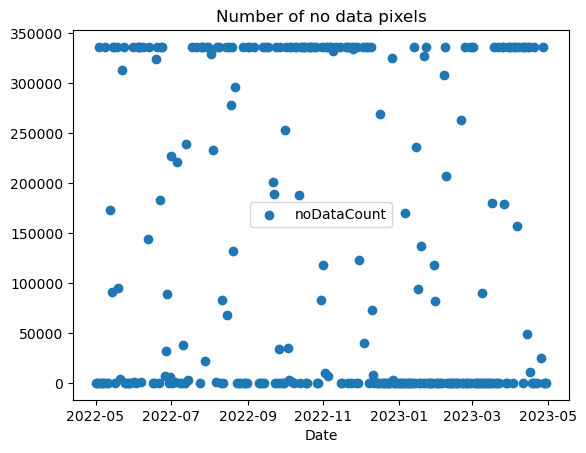

In [20]:
# Plotting the data
plt.scatter(results.index, results['ndwi_noDataCount'], label='noDataCount')


# Adding labels and title
plt.xlabel('Date')
plt.title('Number of no data pixels')
plt.legend()

# Displaying the plot
plt.show()

Lets remove any day that is not entirely covered. Earlier we saw that there were 558,000 pixels total in this AOI

In [21]:
results = results[results['ndwi_noDataCount'] <= 0]
results


ndwi_min  ndwi_max  ndwi_mean  ndwi_stDev  ndwi_sampleCount  \
date                                                                      
2022-05-01 -0.822534  0.508929  -0.530204    0.269937            336400   
2022-05-02 -0.808104  0.583174  -0.501651    0.319878            336400   
2022-05-03 -0.820123  0.780822  -0.499652    0.327996            336400   
2022-05-05 -0.830176  0.595238  -0.494935    0.343375            336400   
2022-05-06 -0.823052  0.516616  -0.483684    0.363841            336400   
...              ...       ...        ...         ...               ...   
2023-04-18 -0.822880  0.666667  -0.556619    0.237783            336400   
2023-04-19 -0.897041  0.907692  -0.507281    0.335753            336400   
2023-04-28 -0.835771  0.747368  -0.536149    0.290838            336400   
2023-04-29 -0.821934  0.604938  -0.537239    0.289949            336400   
2023-04-30 -0.836653  0.959184  -0.565794    0.240286            336400   

            ndwi_noDataCount  
date                          
2022-05-01                 0  
2022-05-02                 0  
2022-05-03                 0  
2022-05-05                 0  
2022-05-06                 0  
...                      ...  
2023-04-18                 0  
2023-04-19                 0  
2023-04-28                 0  
2023-04-29                 0  
2023-04-30                 0  

[127 rows x 6 columns]

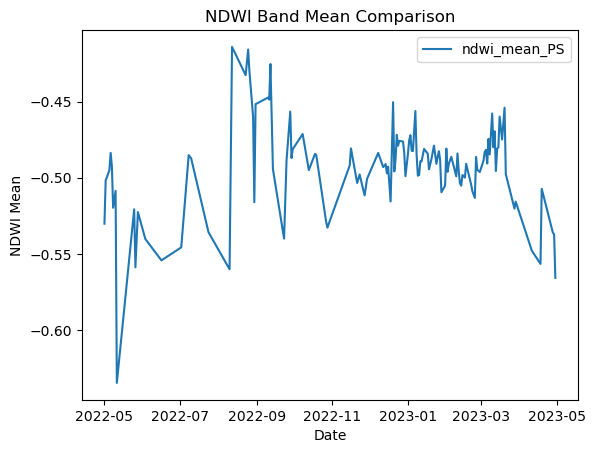

In [22]:
# Plotting the data
plt.plot(results.index, results['ndwi_mean'], label='ndwi_mean_PS')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('NDWI Mean')
plt.title('NDWI Band Mean Comparison')
plt.legend()

# Displaying the plot
plt.show()

The change in NDWI values throughout the year signifies a change in wetness in our AOI. The lower the mean NDWI value the dryer the region which we would imagine would lead to a smaller lake. To confirm this hypothesis we can rudimentarily classify the imagery throughout the year and measure the lake area. 

## Step 3: Water classifiaction using thresholds

We are going to take our NDWI image from earlier and play around with thresholds for classification. Starting at -.6, the highest mean value and slowly working our way up until only the lake outline remains

Text(0.5, 1.0, 'Water Mask September 29th 2022')

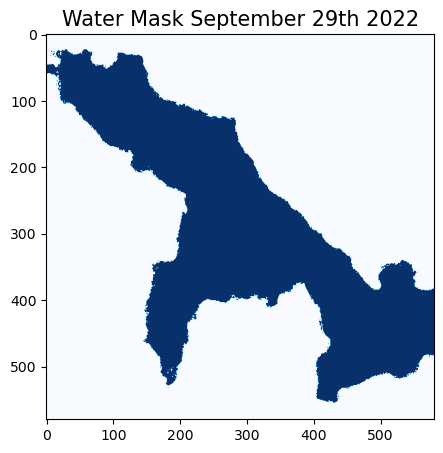

In [23]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))

# Play around with the threshold value till you get a good binary image of the lake
binary = ndwi > -0.4
cax1 = ax1.imshow(binary, cmap="Blues", aspect="auto")
ax1.set_title("Water Mask September 29th 2022", fontsize=15)

Text(0.5, 1.0, 'Water Mask September 29th 2022')

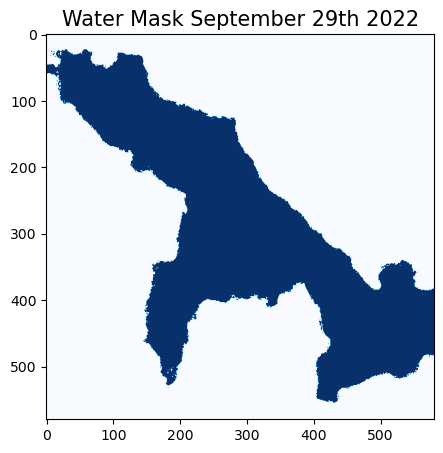

In [24]:

fig, (ax1) = plt.subplots(1, 1, figsize=(5, 5))

# Play around with the threshold value till you get a good binary image of the lake
binary = ndwi > -0.4
cax1 = ax1.imshow(binary, cmap="Blues", aspect="auto")
ax1.set_title("Water Mask September 29th 2022", fontsize=15)


#### Given a threshold we can count the number of pixels above and below that value within our image 

Sentinel Hub has the capability of analyzing multiple images within a time range. This can allow for calculating the mean of RGB or NDWI value per pixel for a given month. Here is the evalscript that will take the sum of each pixel and divide it by the number of pixels present in the time range.

In [25]:
mean_eval = """
//VERSION=3
function setup() {
  return {
    input: ["green", "nir", "dataMask", "cloud_mask"],
    output: { bands: 1,
    sampleType: "FLOAT32"},
    mosaicking: "ORBIT"
  };
}

function evaluatePixel(samples, scenes) {
  var sum_ndwi = 0;
  var count = 0;
  for (var i = 0; i < samples.length; i++) {
    var noCloud = samples[i].cloud_mask == 1 ? 1 : 0;
    var total_mask = samples[i].dataMask * noCloud;
    if (total_mask != 0) {
      sum_ndwi += (samples[i].green - samples[i].nir) / (samples[i].green + samples[i].nir);
      count++;
    }
  }
  return [sum_ndwi / count];
}
"""

Now if we make the call for every month that we have imagery for, starting April 2022. This will take a couple minutes.

In [26]:
year = 2022
start_month = 5
monthly_rasters = []

for i in range(12):
    month = (start_month + i - 1) % 12 + 1
    if month == 1 and i != 0:
        year += 1

    # Get the first day of the month
    first_day = datetime(year, month, 1).strftime('%Y-%m-%d')
    # Get the last day of the month
    last_day = datetime(year, month, calendar.monthrange(year, month)[1]).strftime('%Y-%m-%d')
    print(f"Getting data for {first_day} to {last_day}")
    
    # Store the raster data along with the month and year
    raster_data = request_data(mean_eval, first_day, last_day).get_data()[0]
    monthly_rasters.append({
        "year": year,
        "month": month,
        "raster": raster_data
    })

Getting data for 2022-05-01 to 2022-05-31
Getting data for 2022-06-01 to 2022-06-30
Getting data for 2022-07-01 to 2022-07-31
Getting data for 2022-08-01 to 2022-08-31
Getting data for 2022-09-01 to 2022-09-30
Getting data for 2022-10-01 to 2022-10-31
Getting data for 2022-11-01 to 2022-11-30
Getting data for 2022-12-01 to 2022-12-31
Getting data for 2023-01-01 to 2023-01-31
Getting data for 2023-02-01 to 2023-02-28
Getting data for 2023-03-01 to 2023-03-31
Getting data for 2023-04-01 to 2023-04-30


Lets look at what the ndwi values for the year look like before we classify our imagery

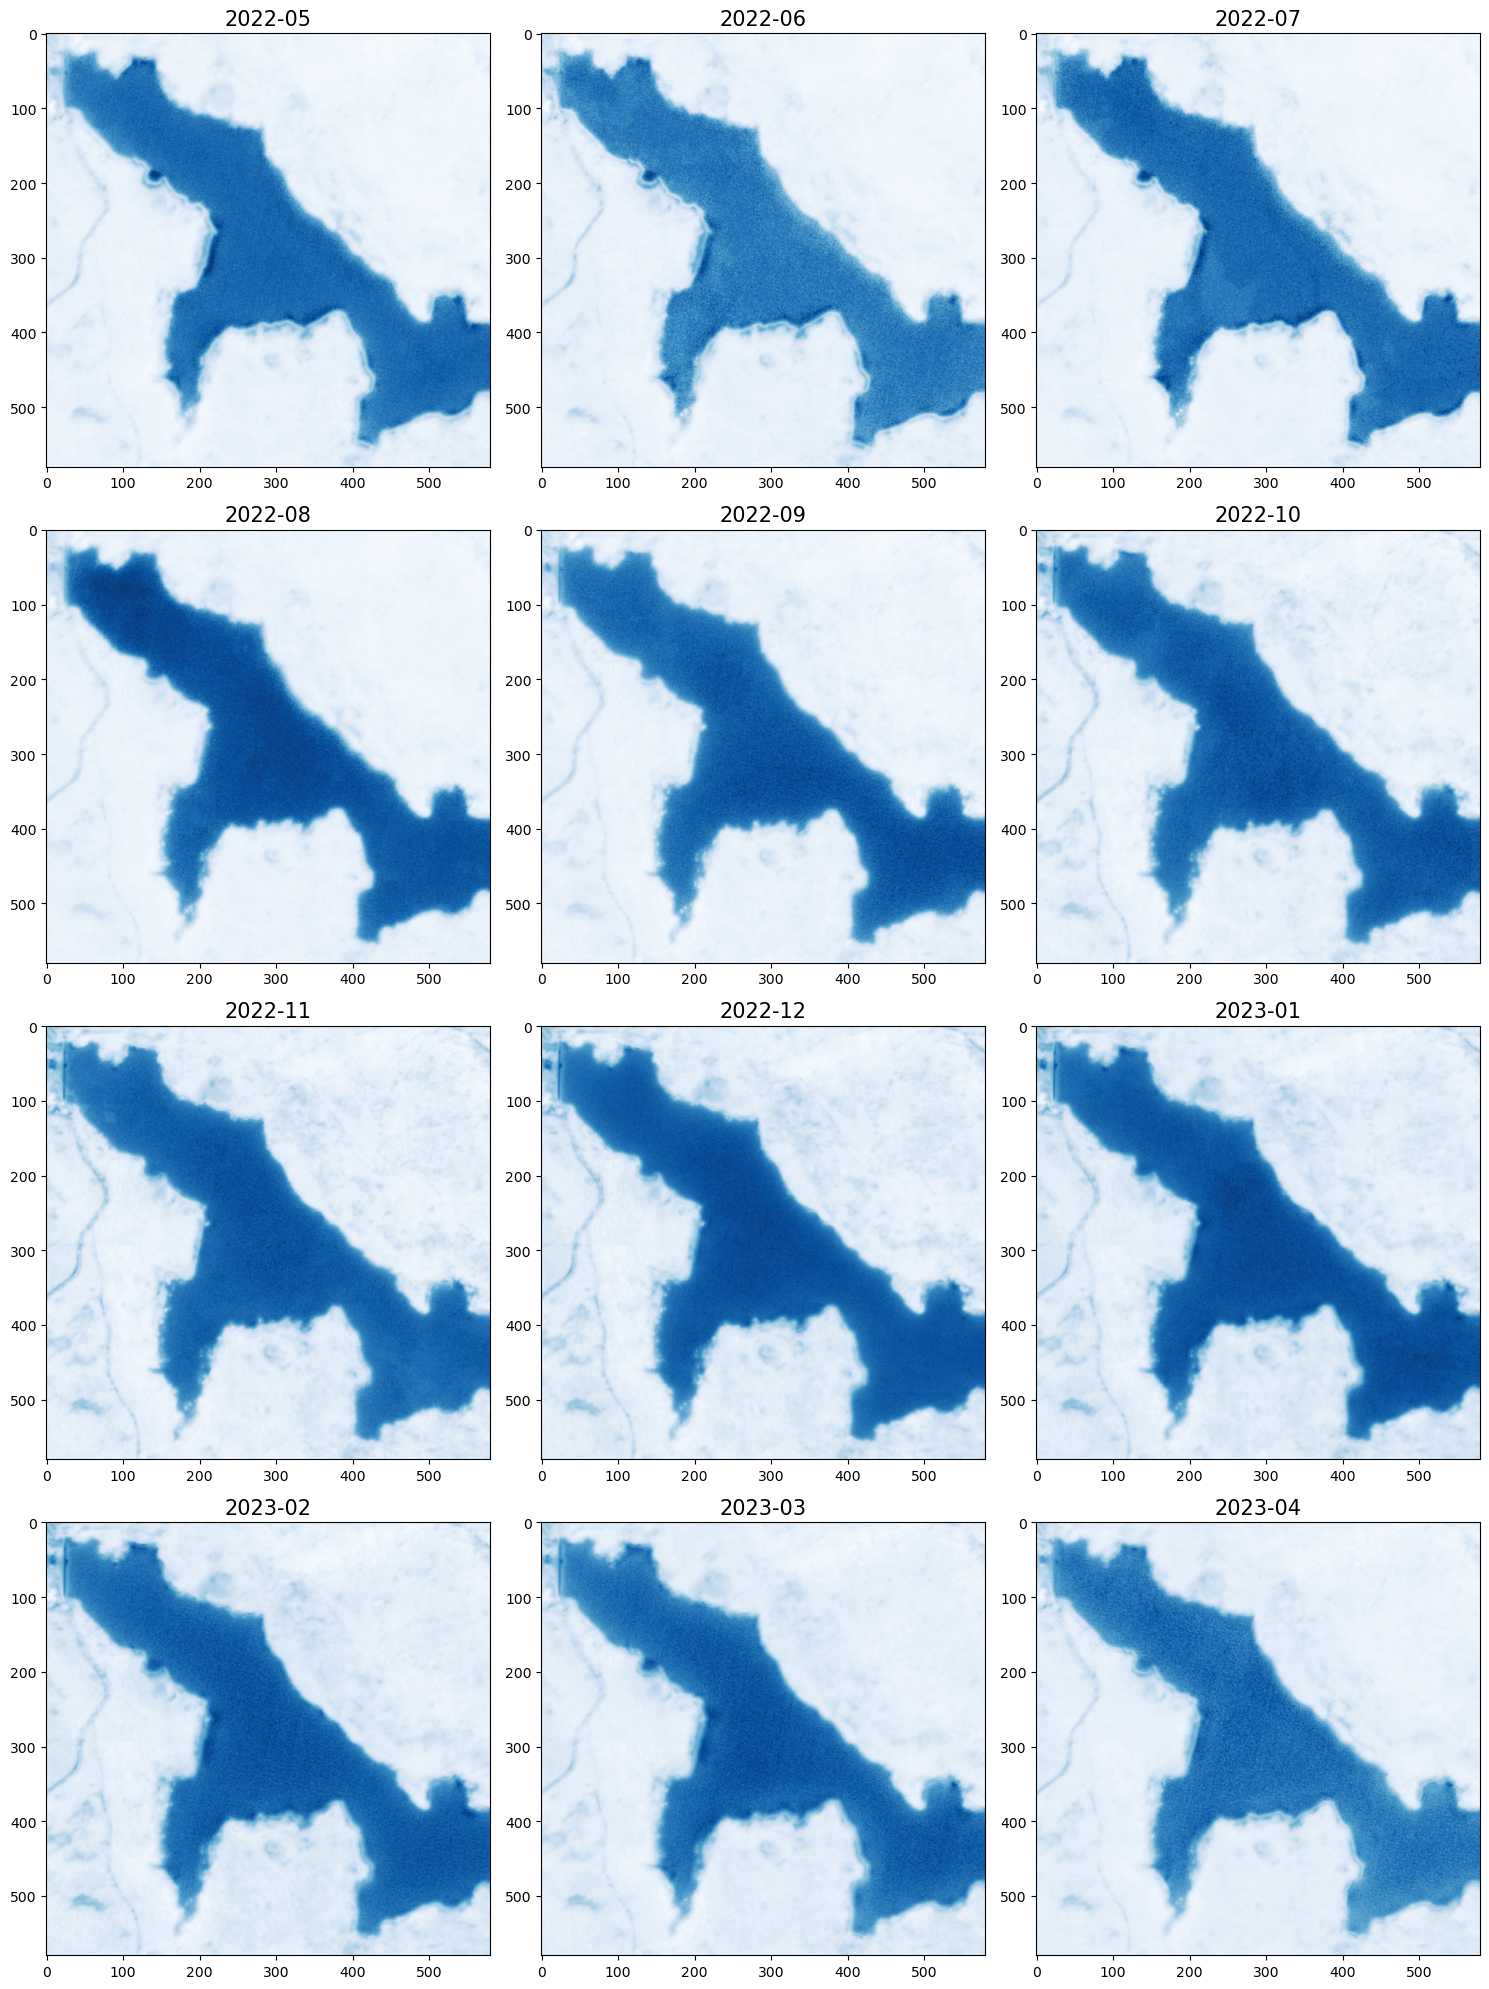

In [27]:
def plot_ndwi_array(monthly_rasters, cmap="Blues"):
    # Create subplots
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, entry in enumerate(monthly_rasters):
        # Extract raster and metadata
        ndwi = entry["raster"]
        year = entry["year"]
        month = entry["month"]

        # Plot each NDWI raster
        cax = axes[i].imshow(ndwi, cmap=cmap, aspect="auto")

        # Set title for each subplot using year and month
        axes[i].set_title(f"{year}-{month:02d}", fontsize=15)

    # Hide any unused subplots
    for j in range(len(monthly_rasters), len(axes)):
        axes[j].axis("off")

    # Add colorbar for each subplot
    plt.tight_layout()
    plt.show()

plot_ndwi_array(monthly_rasters)

Now we can plot all of the images using the threshold that we found above

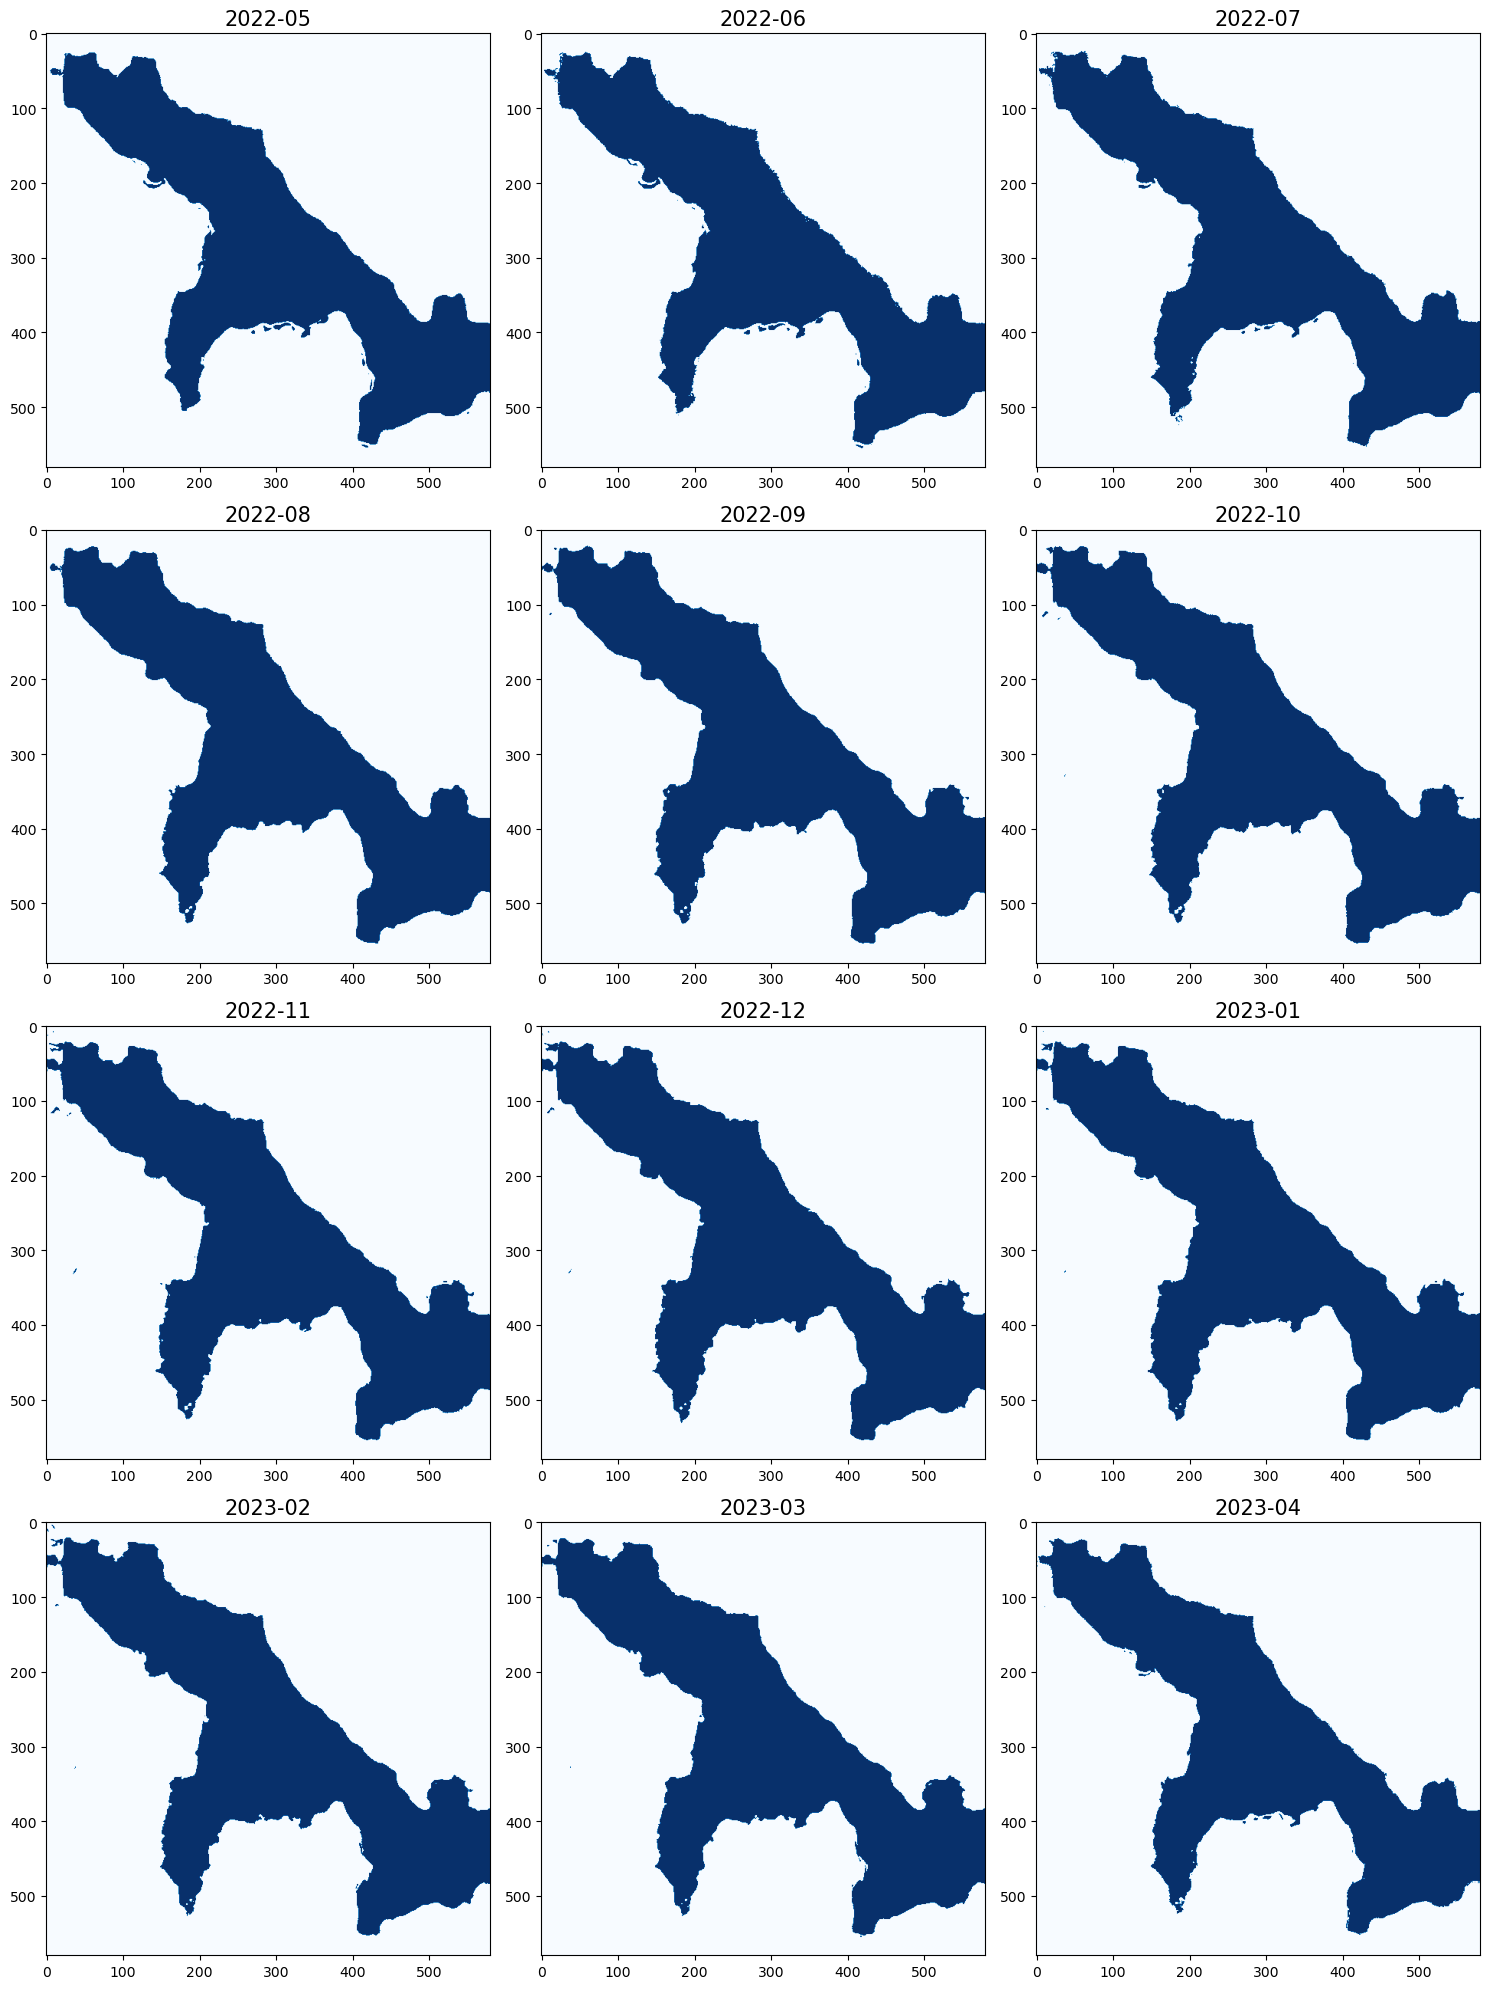

In [28]:
def plot_ndwi_array(monthly_rasters, cmap="Blues"):
    # Create subplots
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i, entry in enumerate(monthly_rasters):
        # Extract raster and metadata
        ndwi = entry["raster"]
        year = entry["year"]
        month = entry["month"]

        # Apply binary threshold to the NDWI raster
        binary = ndwi > -0.40

        # Plot the binary NDWI raster
        cax = axes[i].imshow(binary, cmap=cmap, aspect="auto")

        # Set title for each subplot using year and month
        axes[i].set_title(f"{year}-{month:02d}", fontsize=15)

    # Hide any unused subplots
    for j in range(len(monthly_rasters), len(axes)):
        axes[j].axis("off")

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_ndwi_array(monthly_rasters)

Finally we can count the area of each month by counting the pixels above the monthly threshold. By plotting it we can see the water fluctuation of the Perth Water resevoir through the year.

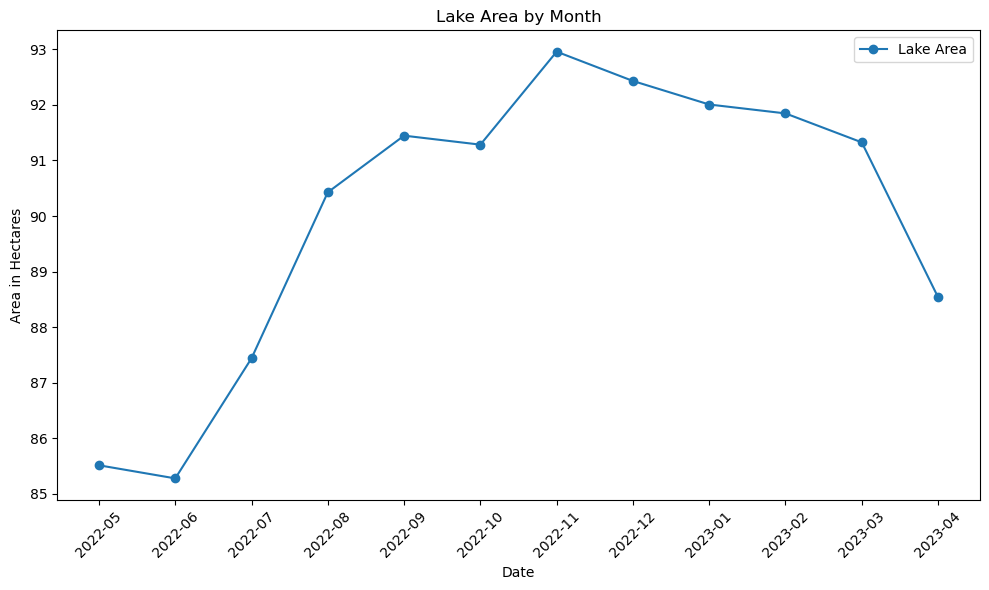

In [29]:
monthly_area = []
dates = []

for entry in monthly_rasters:
    # Extract raster and metadata
    ndwi = entry["raster"]
    year = entry["year"]
    month = entry["month"]

    # Calculate the area where NDWI > -0.40
    area = np.sum(ndwi > -0.40) * 9 / 10000  # Convert to hectares
    monthly_area.append(area)

    # Store the date for the x-axis
    dates.append(f"{year}-{month:02d}")

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(dates, monthly_area, label='Lake Area', marker='o')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Area in Hectares')
plt.title('Lake Area by Month')
plt.xticks(rotation=45)
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()

Our lake area does generally correlate with our earlier wetness/dryness although the largest water extent is measured as far earlier in the season then the wettest point. This basic analysis could be easily repeated year over year to get better annual trends and potentially detect anomalous events in the future!